In [19]:
# Импорт библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from datasets import load_dataset

In [20]:
checkpoint_dir = r"C:\Users\User\Documents\Progs\Projects\food101_nas\checkpoints\2025-08-31_05-29-54_vit_base_patch16_224_batch64"
graphs_dir = os.path.join(checkpoint_dir, 'graphs')  # Для совместимости с будущим сохранением, но не используется

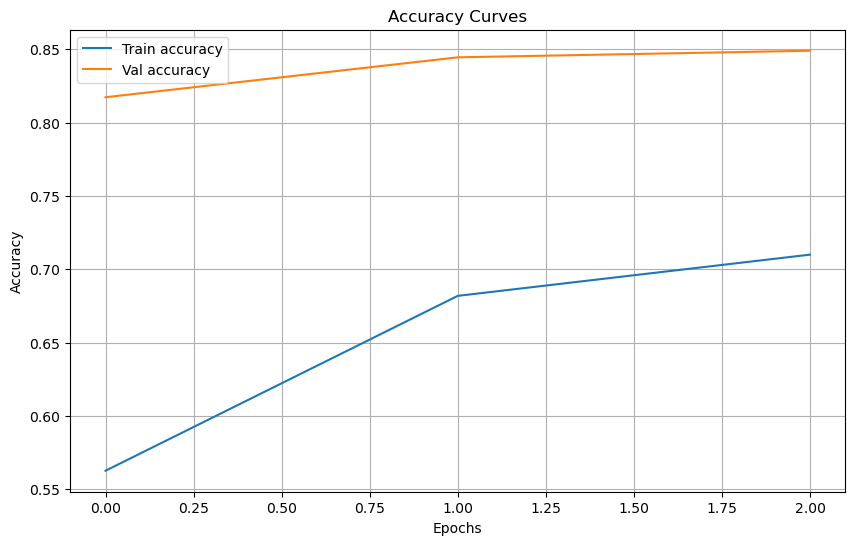

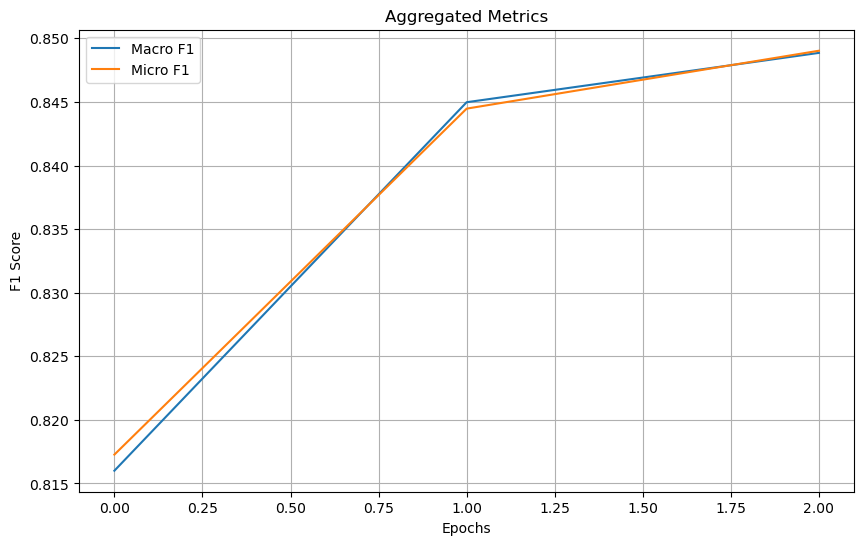

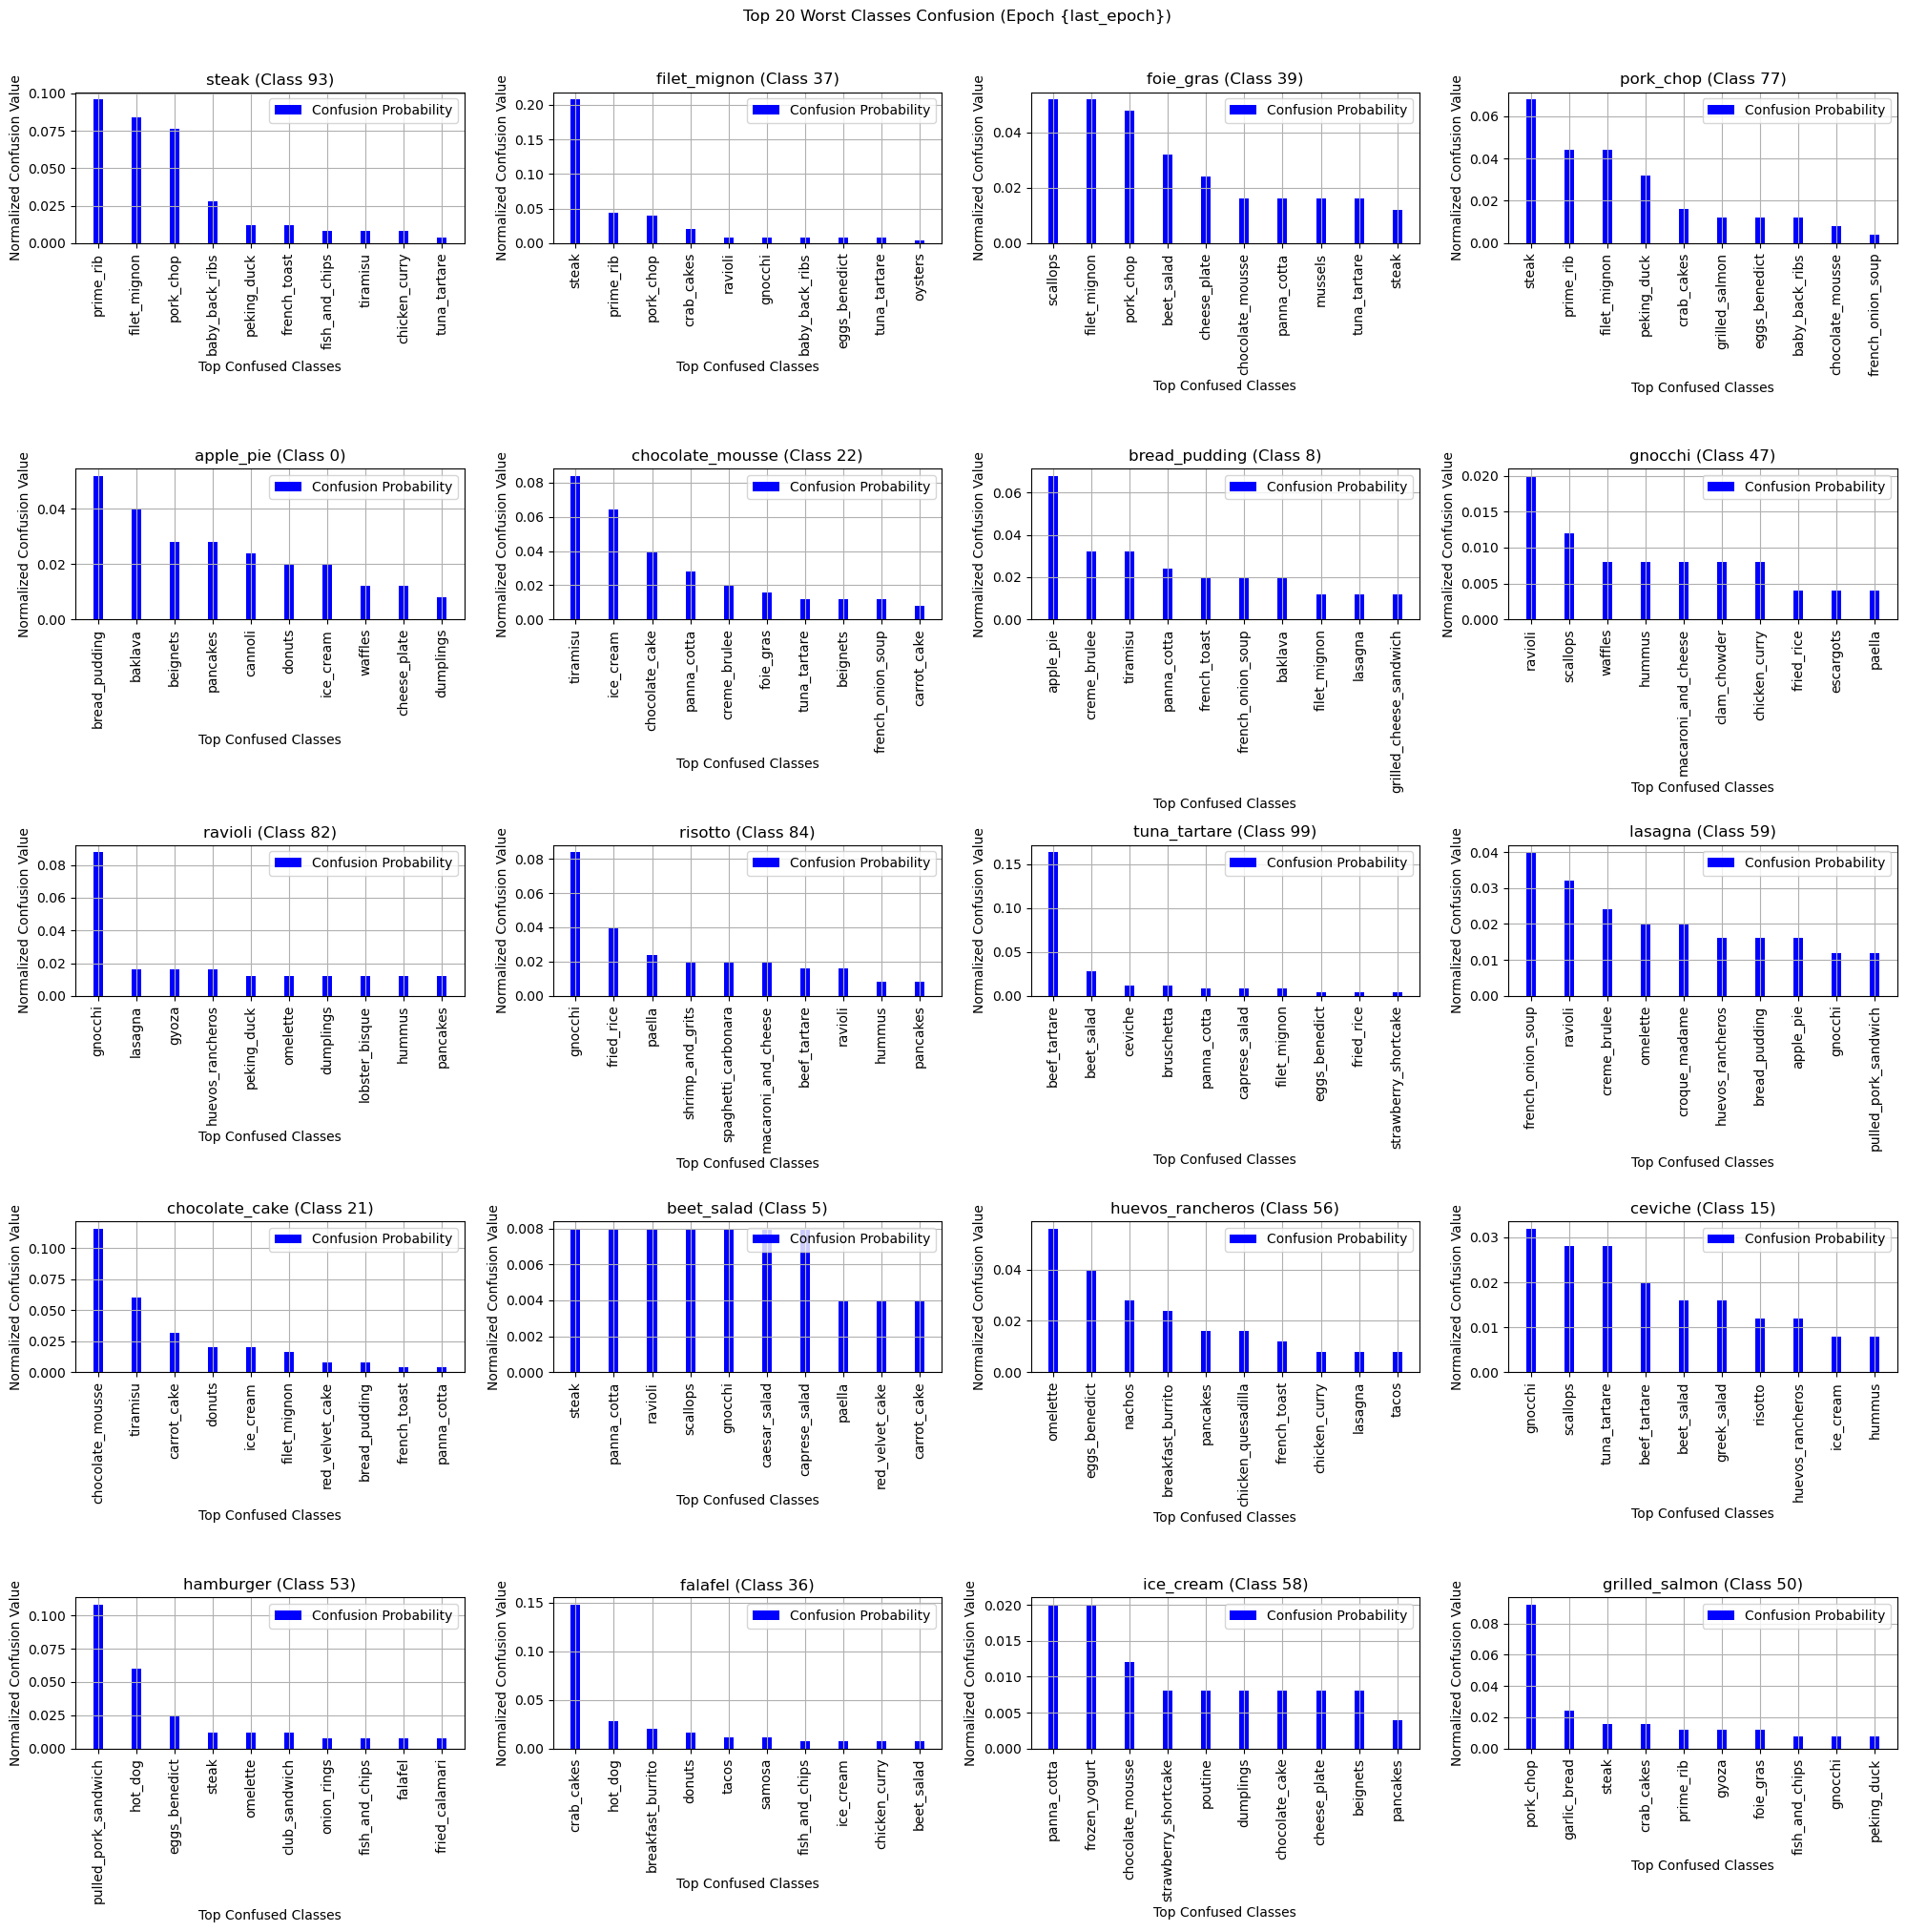

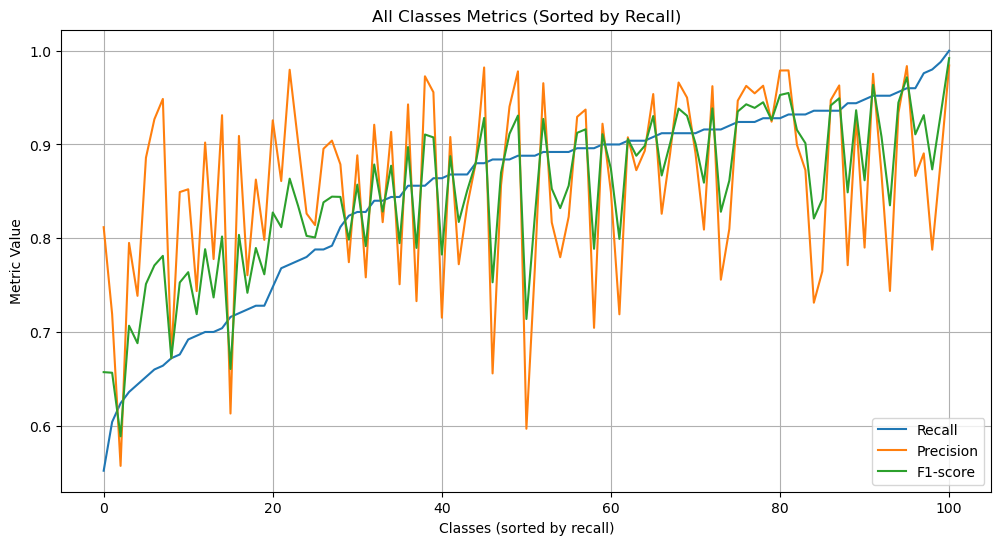

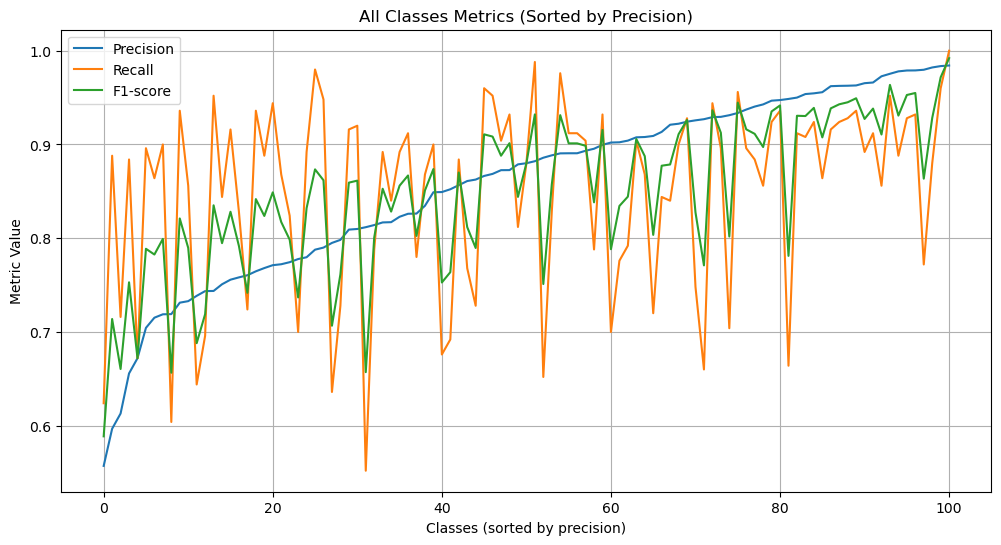

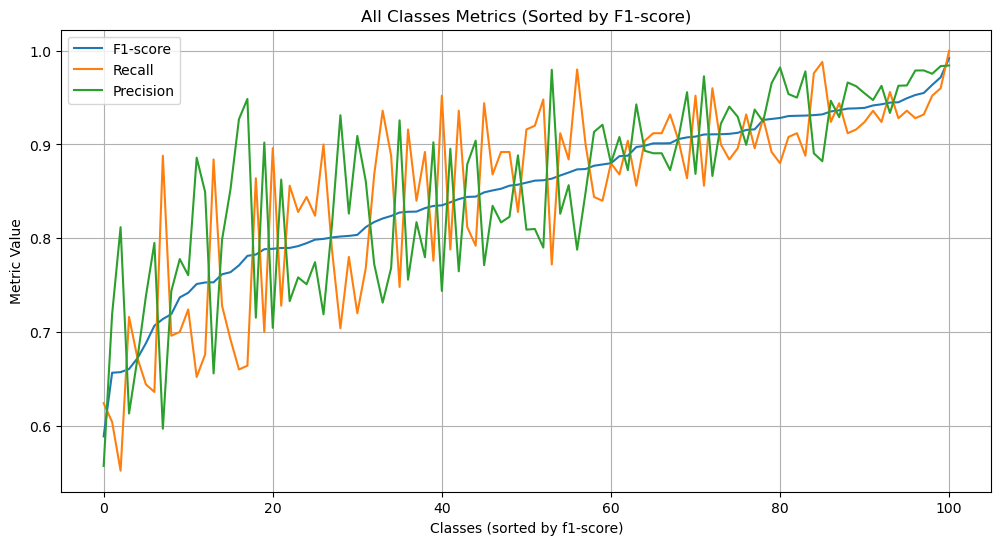

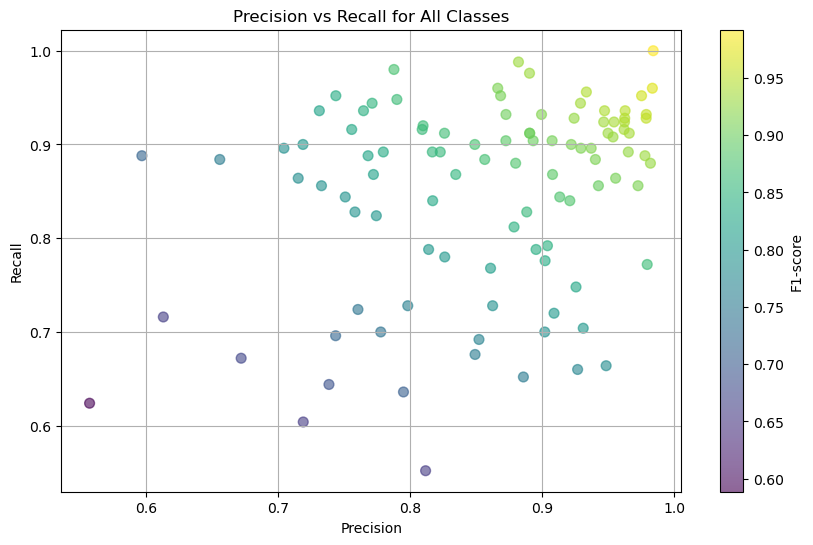

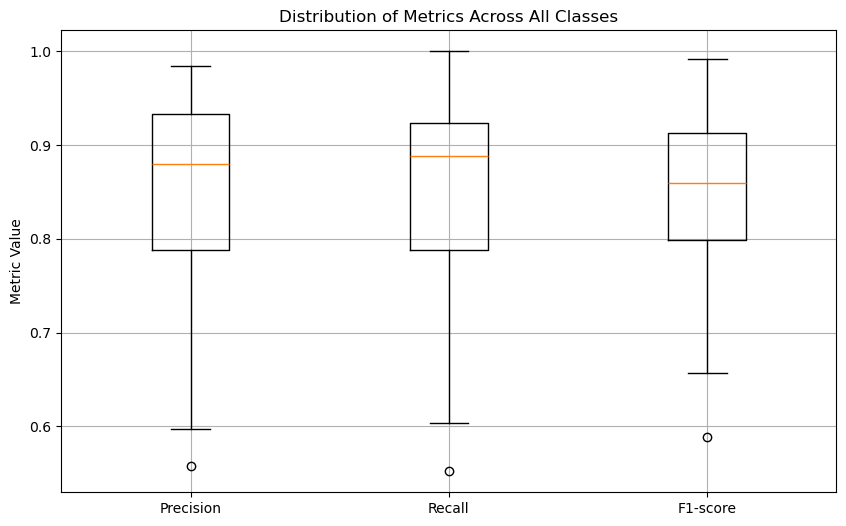

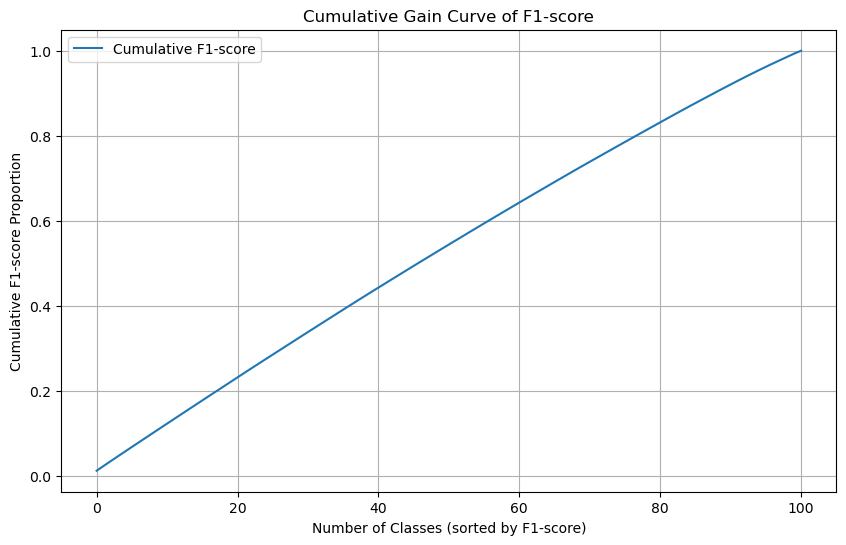

In [ ]:
# Чтение метрик
metrics_file = os.path.join(checkpoint_dir, 'metrics.txt')
epochs = []
train_losses, train_accs, val_losses, val_accs = [], [], [], []
with open(metrics_file, 'r') as f:
    next(f)  # Пропускаем заголовок
    for line in f:
        epoch, train_loss, train_acc, val_loss, val_acc = map(float, line.strip().split(','))
        epochs.append(int(epoch) - 1)  # Индексация с 0
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

# Чтение лейблов для последней эпохи
last_epoch = epochs[-1] + 1
val_labels_path = os.path.join(checkpoint_dir, 'labels', f'epoch_{last_epoch}_val.npy')
val_data = np.load(val_labels_path)
true_labels = val_data[:, 0]
pred_labels = val_data[:, 1]

num_classes = 101

# Получение имен классов из датасета Food-101
dataset = load_dataset("food101")
class_names = dataset["train"].features['label'].names

# График точности по эпохам
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label='Train accuracy')
plt.plot(epochs, val_accs, label='Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()

# График аггреггированных метрик
macro_precision, macro_recall, macro_f1 = [], [], []
micro_precision, micro_recall, micro_f1 = [], [], []

for epoch in range(len(epochs)):
    val_data = np.load(os.path.join(checkpoint_dir, 'labels', f'epoch_{epoch+1}_val.npy'))
    true_labels = val_data[:, 0]
    pred_labels = val_data[:, 1]
    
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro', zero_division=0)
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='micro', zero_division=0)
    macro_precision.append(p_macro)
    macro_recall.append(r_macro)
    macro_f1.append(f1_macro)
    micro_precision.append(p_micro)
    micro_recall.append(r_micro)
    micro_f1.append(f1_micro)

plt.figure(figsize=(10, 6))
plt.plot(epochs, macro_f1, label='Macro F1')
plt.plot(epochs, micro_f1, label='Micro F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Aggregated Metrics')
plt.legend()
plt.grid(True)
plt.show()

# Вычисление confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=range(num_classes))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Нормализованная CM

# Вычисление f1 и support для сортировки
precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels, average=None, labels=range(num_classes), zero_division=0)

# Топ-20 худших классов по F1-score
worst_indices = np.argsort(f1)[:20]
worst_labels = [class_names[i] for i in worst_indices]

# Создание большого графика с subplots для худших классов
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
fig.suptitle('Top 20 Worst Classes Confusion (Epoch {last_epoch})', y=1.01)  # Отступ заголовка

for i, class_id in enumerate(worst_indices):
    row = i // 4
    col = i % 4
    confusions = cm_norm[class_id]
    # Исключаем сам класс (диагональ)
    confusions[class_id] = 0
    top_confusions = np.argsort(confusions)[-10:][::-1]  # Топ-10 путаниц, отсортированные по убыванию
    top_values = confusions[top_confusions]
    top_names = [class_names[j] for j in top_confusions]

    x = np.arange(len(top_names))
    width = 0.25

    axs[row, col].bar(x, top_values, width, label='Confusion Probability', color='blue')
    axs[row, col].set_title(f'{worst_labels[i]} (Class {class_id})')
    axs[row, col].set_xlabel('Top Confused Classes')
    axs[row, col].set_ylabel('Normalized Confusion Value')
    axs[row, col].set_xticks(x)
    axs[row, col].set_xticklabels(top_names, rotation=90)
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

# График всех recall от худшего к лучшему с precision и f1
sorted_indices = np.argsort(recall)
sorted_recall = recall[sorted_indices]
sorted_precision = precision[sorted_indices]
sorted_f1 = f1[sorted_indices]

plt.figure(figsize=(12, 6))
plt.plot(range(num_classes), sorted_recall, label='Recall')
plt.plot(range(num_classes), sorted_precision, label='Precision')
plt.plot(range(num_classes), sorted_f1, label='F1-score')
plt.xlabel('Classes (sorted by recall)')
plt.ylabel('Metric Value')
plt.title('All Classes Metrics (Sorted by Recall)')
plt.legend()
plt.grid(True)
plt.show()

# График всех precision от худшего к лучшему с recall и f1
sorted_indices = np.argsort(precision)
sorted_precision = precision[sorted_indices]
sorted_recall = recall[sorted_indices]
sorted_f1 = f1[sorted_indices]

plt.figure(figsize=(12, 6))
plt.plot(range(num_classes), sorted_precision, label='Precision')
plt.plot(range(num_classes), sorted_recall, label='Recall')
plt.plot(range(num_classes), sorted_f1, label='F1-score')
plt.xlabel('Classes (sorted by precision)')
plt.ylabel('Metric Value')
plt.title('All Classes Metrics (Sorted by Precision)')
plt.legend()
plt.grid(True)
plt.show()

# График всех f1 от худшего к лучшему с recall и precision
sorted_indices = np.argsort(f1)
sorted_f1 = f1[sorted_indices]
sorted_recall = recall[sorted_indices]
sorted_precision = precision[sorted_indices]

plt.figure(figsize=(12, 6))
plt.plot(range(num_classes), sorted_f1, label='F1-score')
plt.plot(range(num_classes), sorted_recall, label='Recall')
plt.plot(range(num_classes), sorted_precision, label='Precision')
plt.xlabel('Classes (sorted by f1-score)')
plt.ylabel('Metric Value')
plt.title('All Classes Metrics (Sorted by F1-score)')
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot метрик (Precision vs Recall)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(precision, recall, c=f1, cmap='viridis', s=50, alpha=0.6)
plt.colorbar(scatter, label='F1-score')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall for All Classes')
plt.grid(True)
plt.show()

# Box Plot распределения метрик
plt.figure(figsize=(10, 6))
plt.boxplot([precision, recall, f1], tick_labels=['Precision', 'Recall', 'F1-score'])
plt.title('Distribution of Metrics Across All Classes')
plt.ylabel('Metric Value')
plt.grid(True)
plt.show()

# Кумулятивная кривая F1-score
sorted_f1_indices = np.argsort(f1)[::-1]  # От лучших к худшим
cumulative_f1 = np.cumsum(np.sort(f1)[::-1]) / np.sum(f1)
plt.figure(figsize=(10, 6))
plt.plot(range(num_classes), cumulative_f1, label='Cumulative F1-score')
plt.xlabel('Number of Classes (sorted by F1-score)')
plt.ylabel('Cumulative F1-score Proportion')
plt.title('Cumulative Gain Curve of F1-score')
plt.legend()
plt.grid(True)
plt.show()